**Author:** *Johannes Peter Knoll*

# Introduction

This Notebook is supposed to demonstrate the results of all calculations that are made in
the main.py file

In [1]:
# The autoreload extension allows you to tweak the code in the imported modules
# and rerun cells to reflect the changes.
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Parameters and Files

In [2]:
import random
import numpy as np

In [3]:
# import secondary python files
import main
import read_edf
import MAD
import rpeak_detection
import check_data
import plot_helper
from side_functions import *


The manually chosen ECG thresholds will be used. If you want to recalculate the thresholds, please set the 'use_manually_chosen_ecg_thresholds' parameter to False in the settings section of the script



In [4]:
parameters = main.parameters

In [5]:
PREPARATION_DIRECTORY = main.PREPARATION_DIRECTORY
PREPARATION_RESULTS_NAME = main.PREPARATION_RESULTS_NAME

ADDITIONS_RAW_DATA_DIRECTORY = main.ADDITIONS_RAW_DATA_DIRECTORY

additions_results_path = parameters["additions_results_path"]

# Preparation and Additions

## ECG Validation

### Straighten the ECG signal:

To improve the recognition of valid ECG regions the signal should be "straightened" first.

Here you can see the result of this:

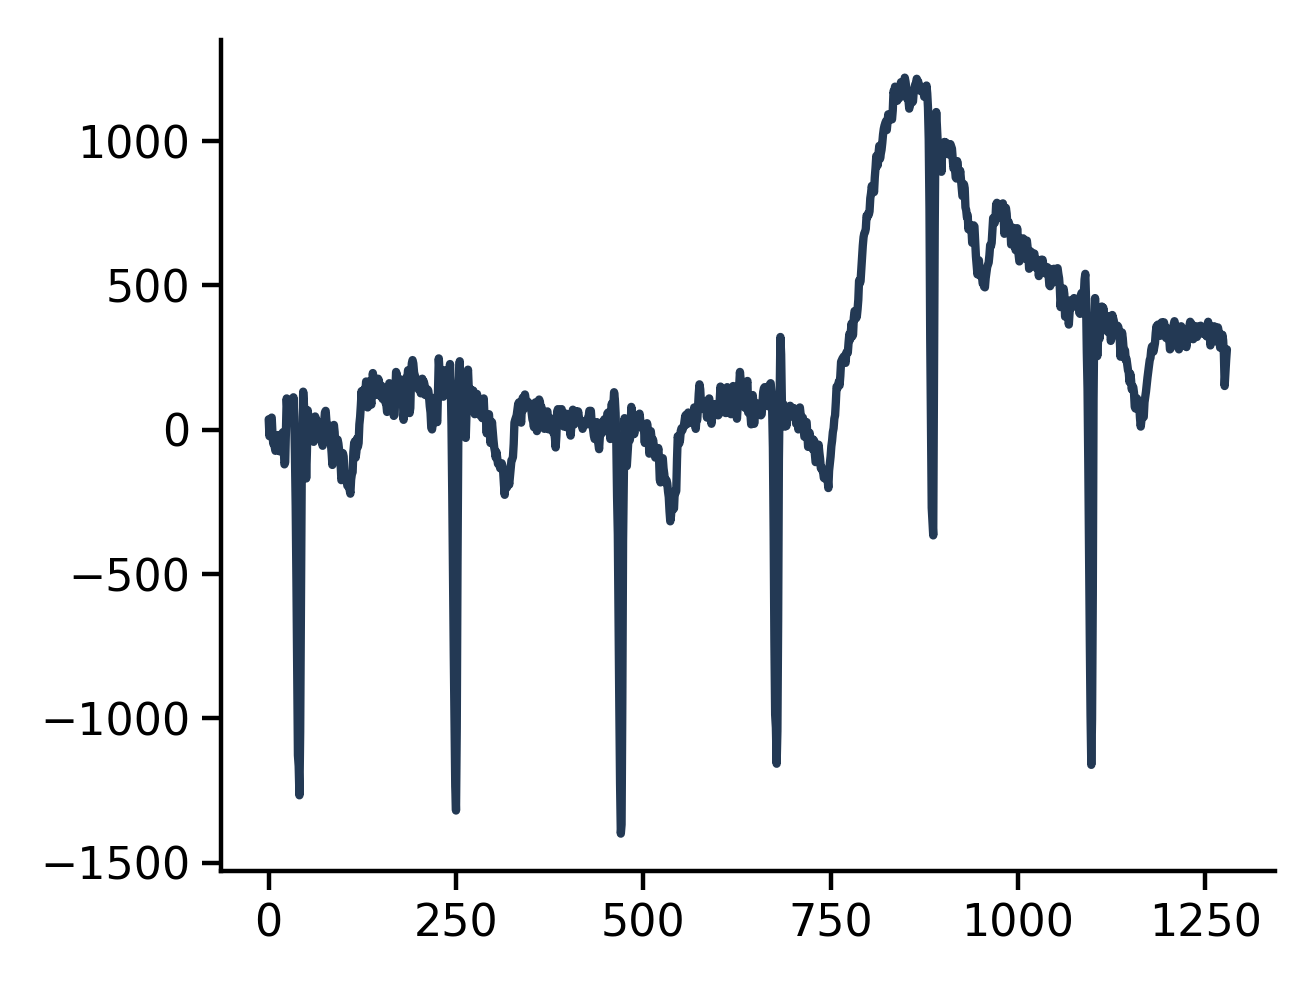

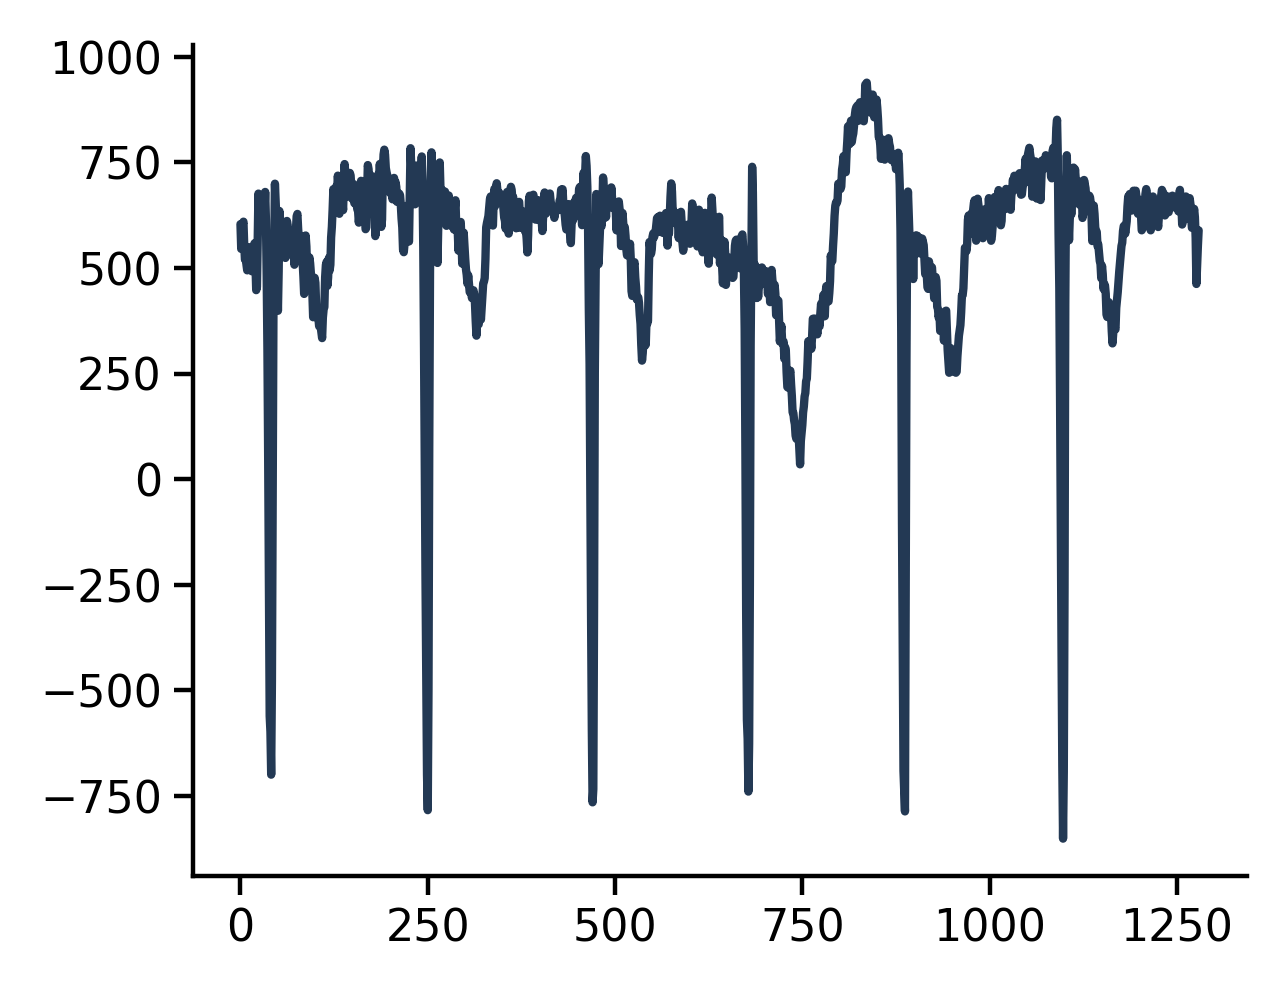

In [96]:
# choose a random file
data_directory = "Data/"
file_data_name = "Somnowatch_Messung.edf"
file_data_path = data_directory + file_data_name

# load the ECG data
ECG, frequency = read_edf.get_data_from_edf_channel(
    file_path = file_data_path,
    possible_channel_labels = parameters["ecg_keys"],
    physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

lower_border = 1012500
interval_size = 1280
interval = [lower_border, lower_border + interval_size]
ecg_signal = ECG[lower_border:lower_border + interval_size]

plot_helper.simple_plot(ecg_signal)

straightened_ecg = check_data.straighten_ecg(ecg_signal, frequency)

plot_helper.simple_plot(straightened_ecg)

### Evaluate and show valid ECG regions:

Here you can evaluate and plot the valid regions of the ECG data from scratch.

Go ahead and change the file_name and xlim to see different data in different intervals!

(Valid / Total) Regions Ratio: 78.130000 %


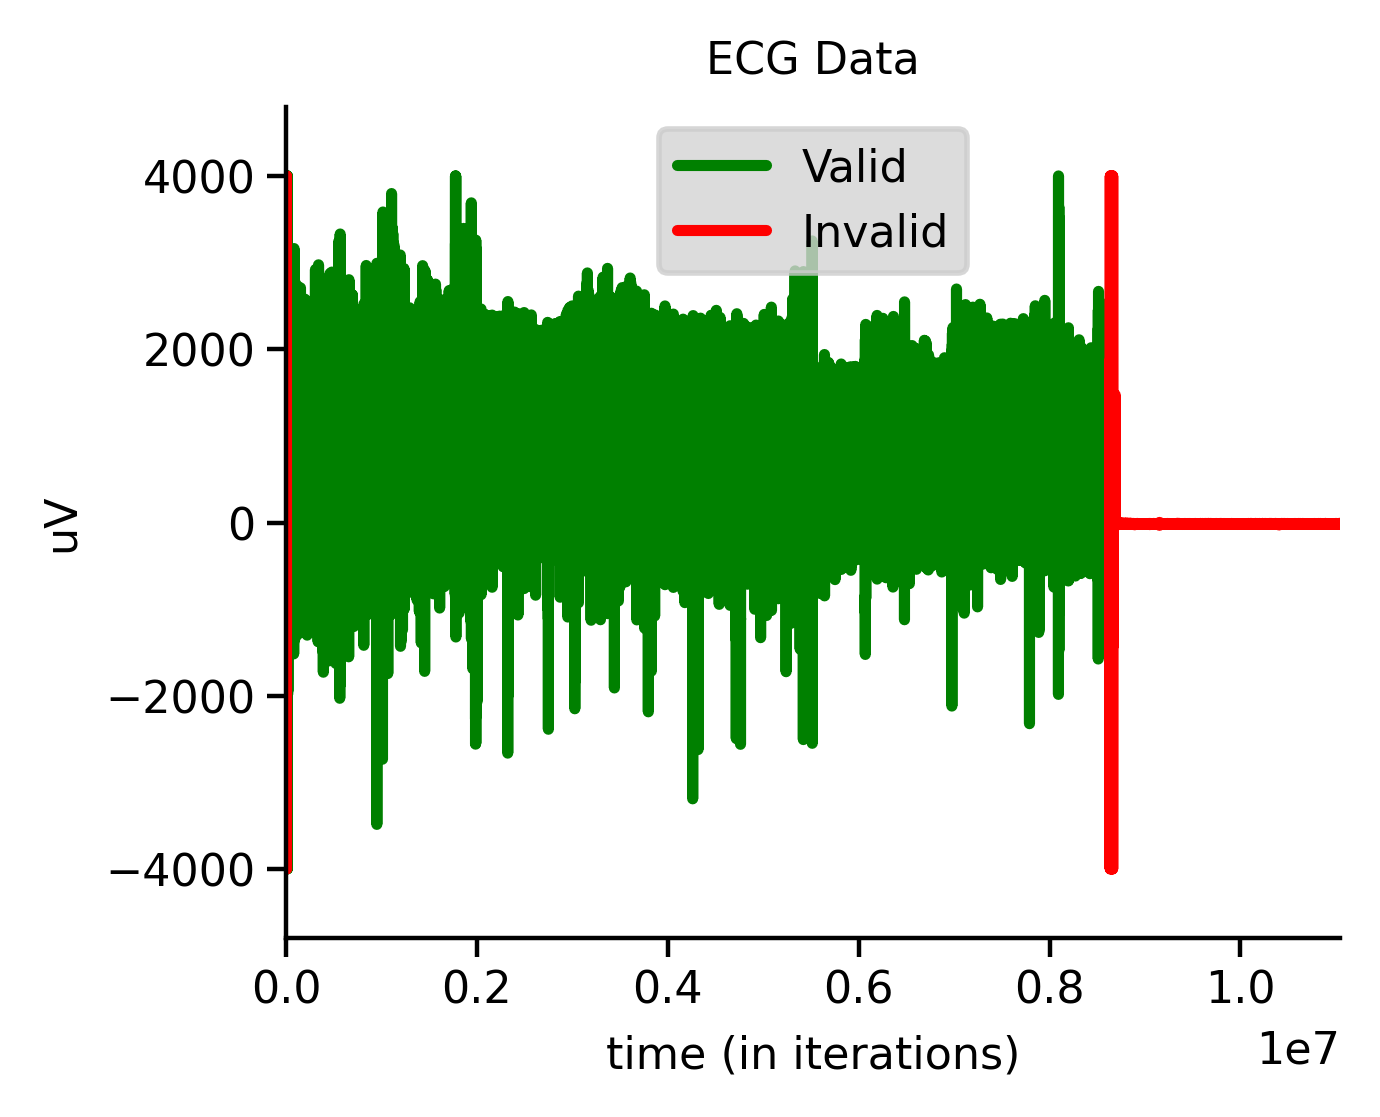

In [95]:
# choose a random file
data_directory = "Data/GIF/SOMNOwatch/"
file_data_name = "Somnowatch_Messung.edf"
file_data_name = "SL104_SL104_(1).edf"
file_data_path = data_directory + file_data_name

# load the ECG data
ECG, frequency = read_edf.get_data_from_edf_channel(
    file_path = file_data_path,
    possible_channel_labels = parameters["ecg_keys"],
    physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

results = check_data.check_ecg(
    ECG=ECG, 
    frequency=frequency, 
    check_ecg_time_interval_seconds=5,  
    straighten_ecg_signal=True, 
    check_ecg_overlapping_interval_steps=1, 
    check_ecg_validation_strictness=0.5,
    check_ecg_removed_peak_difference_threshold=0.3,
    check_ecg_std_min_threshold=80,
    check_ecg_std_max_threshold=800,
    check_ecg_distance_std_ratio_threshold=5,
    check_ecg_allowed_invalid_region_length_seconds=30,
    check_ecg_min_valid_length_minutes=5,
    ecg_comparison_mode = False,
    )
valid_regions = results[1][0] # looks weird I know, but it is the way it is (reason is behind ecg validation comparison)

# calculate the ratio of valid regions to total regions
valid_regions_ratio = check_data.valid_total_ratio(
    ECG = ECG, 
    valid_regions = valid_regions
    )
print("(Valid / Total) Regions Ratio: %f %%" % (round(valid_regions_ratio, 4)*100))

# choose region to plot
total_length = len(ECG)
x_lim = [int(0*total_length), int(1*total_length)]

plot_helper.plot_valid_regions(
    ECG = ECG, 
    valid_regions = valid_regions,
    xlim = x_lim
    )

### Show evaluated valid ECG regions

Here you can plot the result of the ECG validation performed when running main.py

(Valid / Total) Regions Ratio: 41.820000 %


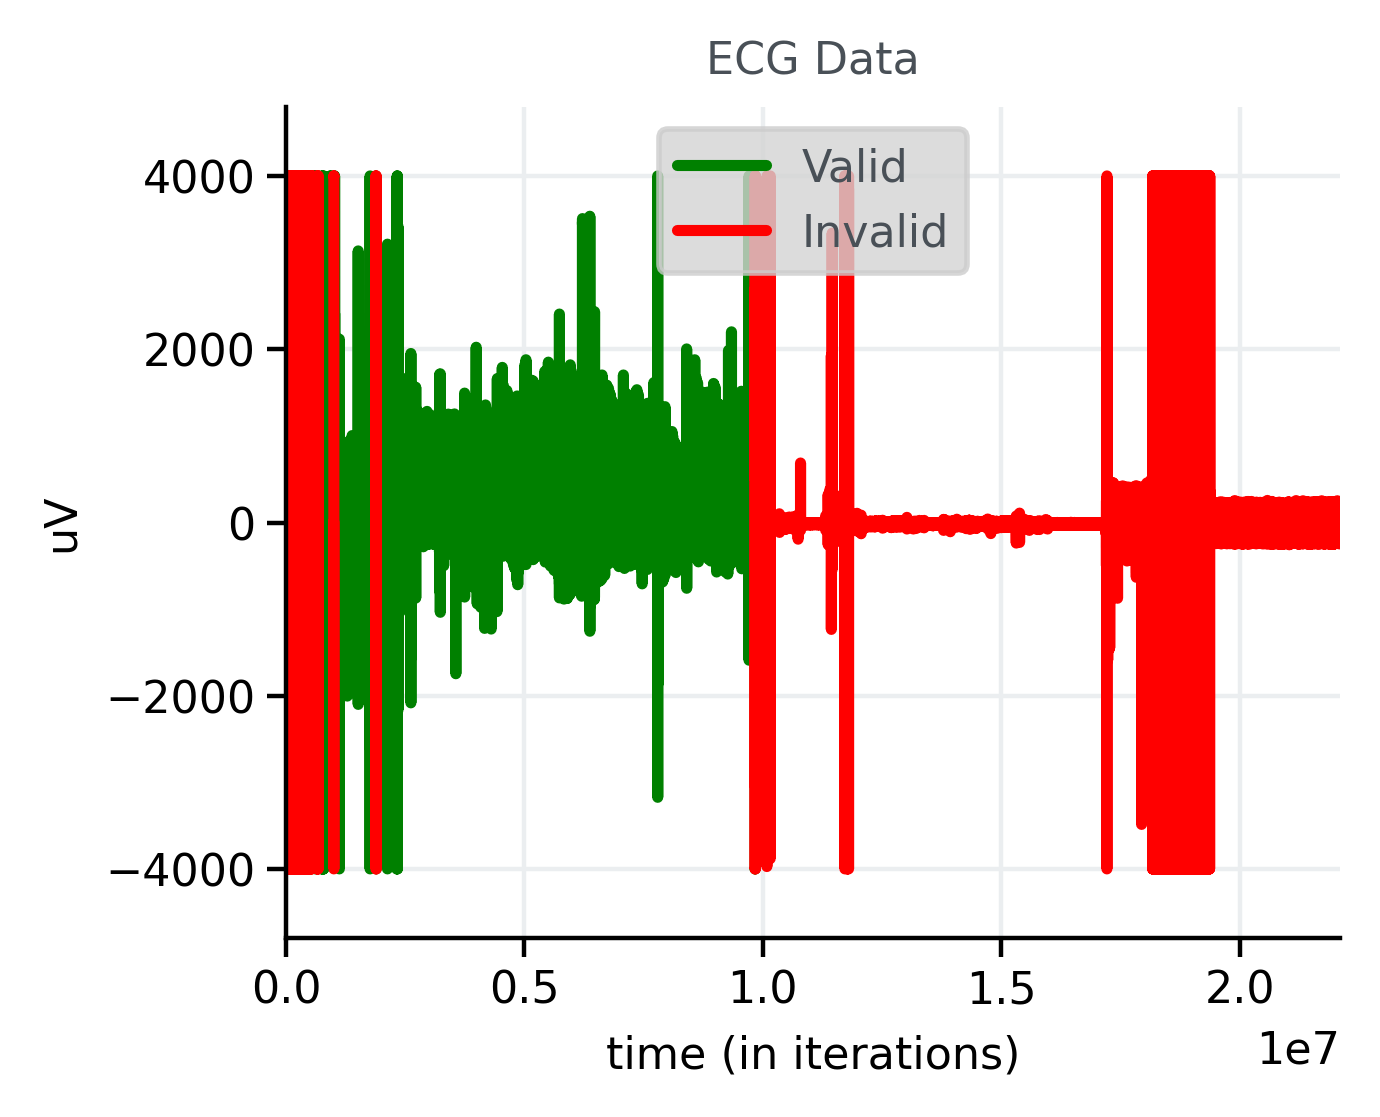

In [19]:
# choose a random file
data_directory = "Data/"
file_data_name = "Somnowatch_Messung.edf"

preparation_results_path = PREPARATION_DIRECTORY + data_directory + PREPARATION_RESULTS_NAME
file_data_path = data_directory + file_data_name

# load the valid regions
preparation_results_generator = load_from_pickle(preparation_results_path)
for generator_entry in preparation_results_generator:
    if generator_entry[parameters["file_name_dictionary_key"]] == file_data_name:
        this_files_valid_ecg_regions = generator_entry[parameters["valid_ecg_regions_dictionary_key"]]
        break

# load the ECG data
ECG, frequency = read_edf.get_data_from_edf_channel(
    file_path = file_data_path,
    possible_channel_labels = parameters["ecg_keys"],
    physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

# calculate the ratio of valid regions to total regions
valid_regions_ratio = check_data.valid_total_ratio(
    ECG = ECG, 
    valid_regions = this_files_valid_ecg_regions
    )
print("(Valid / Total) Regions Ratio: %f %%" % (round(valid_regions_ratio, 4)*100))

total_length = len(ECG)
x_lim = [int(0*total_length), int(1*total_length)]

plot_helper.plot_valid_regions(
    ECG = ECG, 
    valid_regions = this_files_valid_ecg_regions,
    xlim = x_lim
    )

## ECG Validation Comparison

### Compare ECG validation and GIF classification

Compare evaluated and from GIF classification retrieved ECG validation:

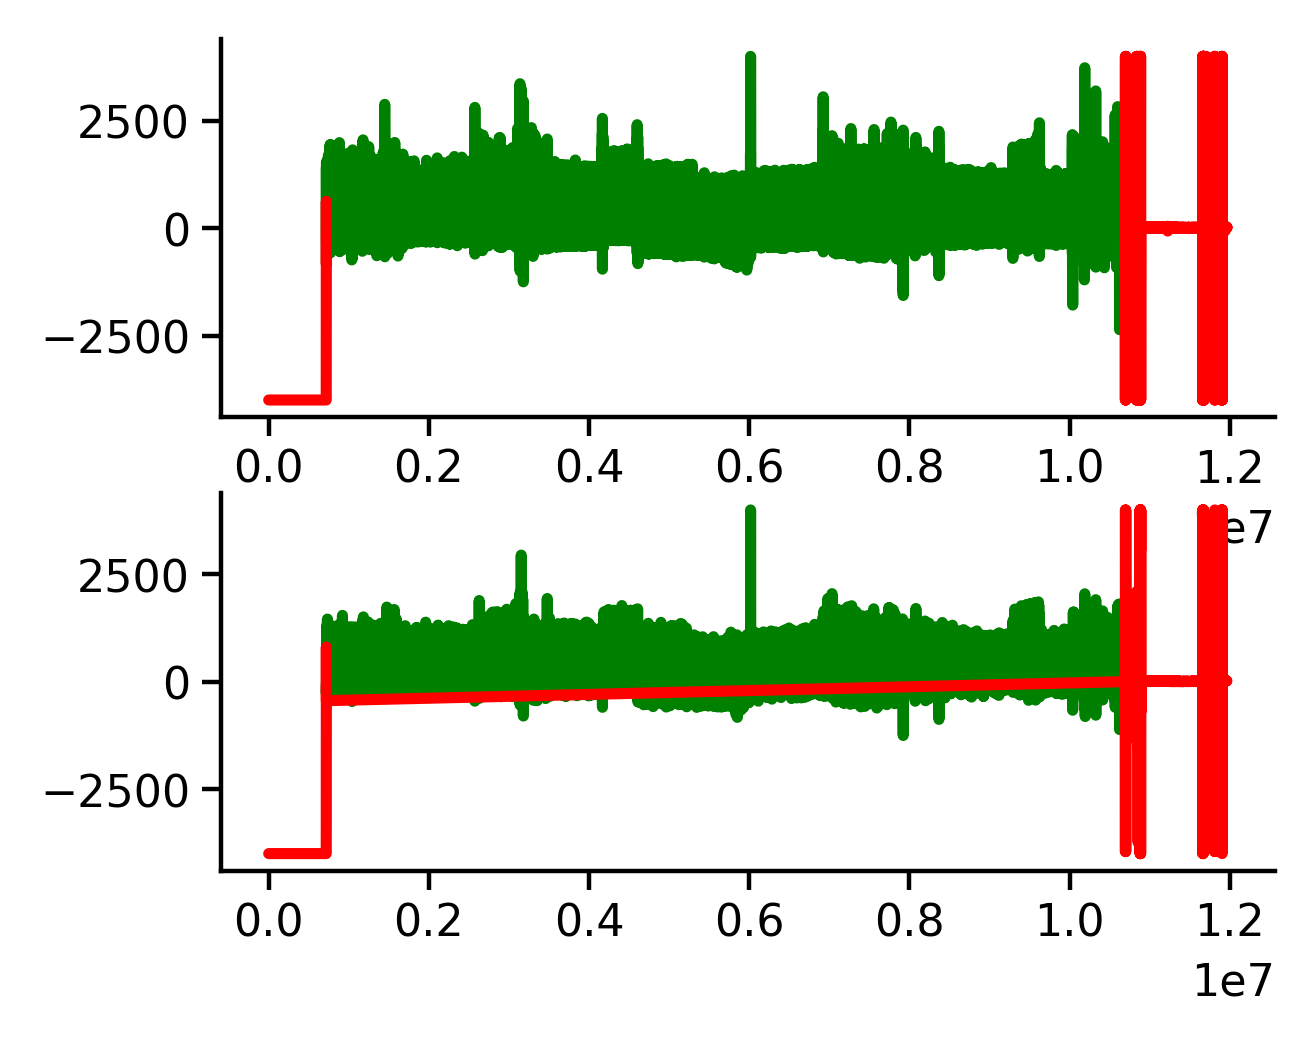

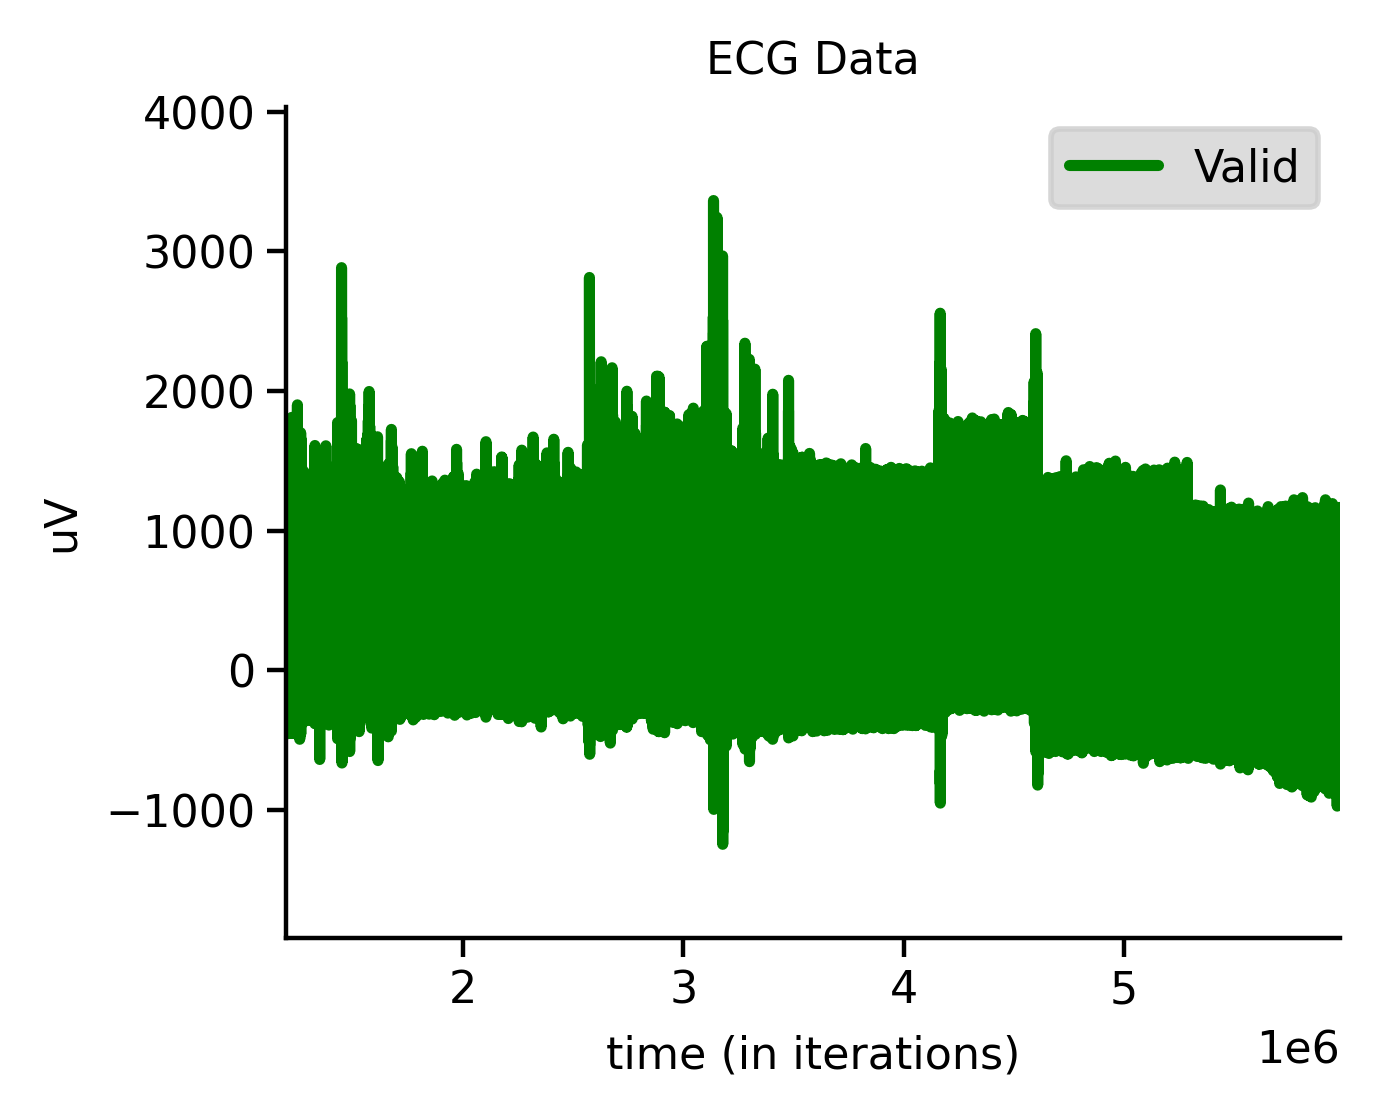

In [125]:
# choose random file
file_data_name = "SL001_SL001_(1).edf"
file_class_name = file_data_name[:-4] + "Somno.txt"
file_data_path = ADDITIONS_RAW_DATA_DIRECTORY + file_data_name
file_class_path = parameters["ecg_classification_values_directory"] + file_class_name

# choose validation_strictness
validation_strictness = 0.5

# load the ECG data
ECG, frequency = read_edf.get_data_from_edf_channel(
    file_path = file_data_path,
    possible_channel_labels = parameters["ecg_keys"],
    physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

# get the classification values
ecg_classification_dictionary = check_data.get_ecg_classification_from_txt_file(file_class_path)

# retrieve evaluated valid regions
additions_results_generator = load_from_pickle(additions_results_path)
for generator_entry in additions_results_generator:
    if generator_entry[parameters["file_name_dictionary_key"]] == file_data_name:
        this_files_valid_ecg_regions = generator_entry[parameters["valid_ecg_regions_dictionary_key"] + "_" + str(validation_strictness)]
        break

# plot the valid regions for easy comparison
plot_helper.plot_ecg_validation_comparison(
    ECG = ECG, 
    valid_regions = this_files_valid_ecg_regions,
    ecg_classification = ecg_classification_dictionary,
)

# afterwards look at a specific region that does not match
total_length = len(ECG)
x_lim = [int(0.1*total_length), int(0.5*total_length)]

plot_helper.plot_valid_regions(
    ECG = ECG, 
    valid_regions = this_files_valid_ecg_regions,
    xlim = x_lim
    )

## Calculating r-peaks

### Calculating r-peaks from scratch

The following code will calculate the r-peaks from scratch for the given file.
Be careful, as you need to choose an interval yourself

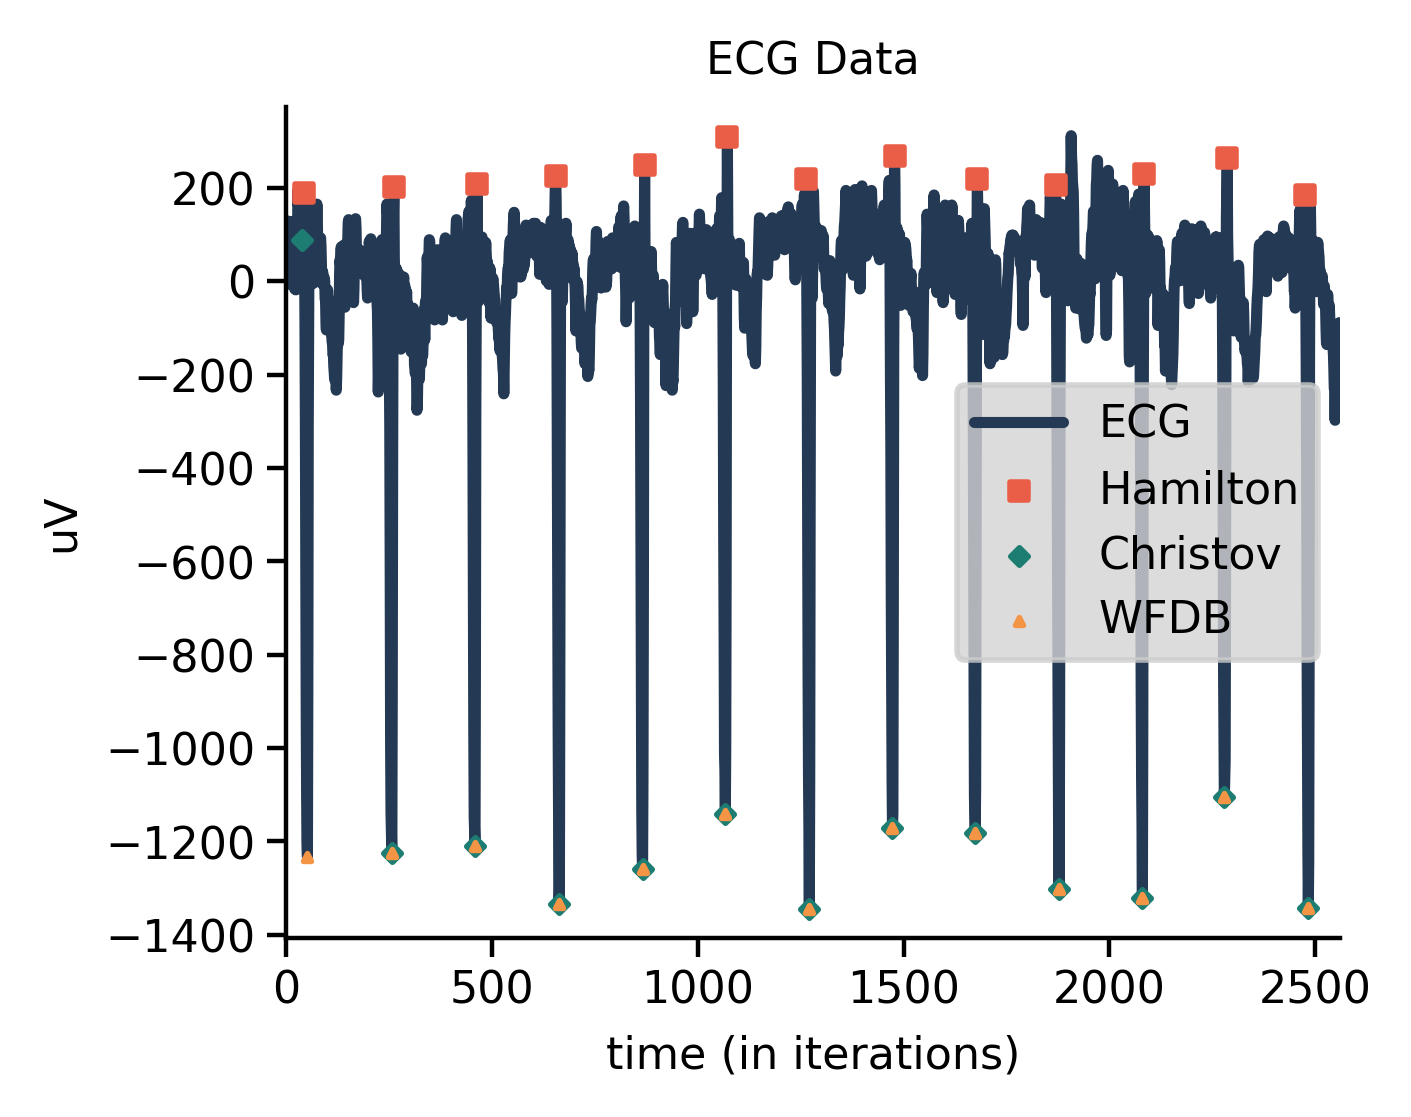

In [12]:
# choose a random file
data_directory = "Calibration_Data/"
file_data_name = "Somnowatch_Messung.edf"

# choose interval
interval_size = 2560
lower_bound = 1781760
interval = [lower_bound, lower_bound + interval_size]

# load the ECG data
ECG, frequency = read_edf.get_data_from_edf_channel(
    file_path = data_directory + file_data_name,
    possible_channel_labels = parameters["ecg_keys"],
    physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

ecg_signal = ECG[interval[0]:interval[1]]

# calculate r-peaks
rpeaks_hamilton = rpeak_detection.get_rpeaks_hamilton(ecg_signal, frequency, None) # type: ignore
rpeaks_christov = rpeak_detection.get_rpeaks_christov(ecg_signal, frequency, None) # type: ignore
rpeaks_wfdb = rpeak_detection.get_rpeaks_wfdb(ecg_signal, frequency, None) # type: ignore
rpeaks_ecgdet = rpeak_detection.get_rpeaks_ecgdetectors(ecg_signal, frequency, None) # type: ignore

# plot the r-peaks
plot_helper.plot_rpeak_detection(
    ECG = ecg_signal,
    rpeaks = [rpeaks_hamilton,rpeaks_christov,rpeaks_wfdb],
    rpeaks_name = ["Hamilton","Christov","WFDB"],
)

### Plot already calculated r-peaks

In the following you can look at already calculated r-peaks. 

This has the one advantage that you do not need to worry about finding a valid ecg region first.

The calculated r-peaks will be plotted in a random valid ECG interval. Of course you can change the
interval size or even define the interval yourself. Go ahead and look at a few different intervals
for different files!

ATTENTION: valid ECG regions and r-peaks must have been compiled first (see main.py - PREPARATION SECTION or ADDITIONALS_SECTION)

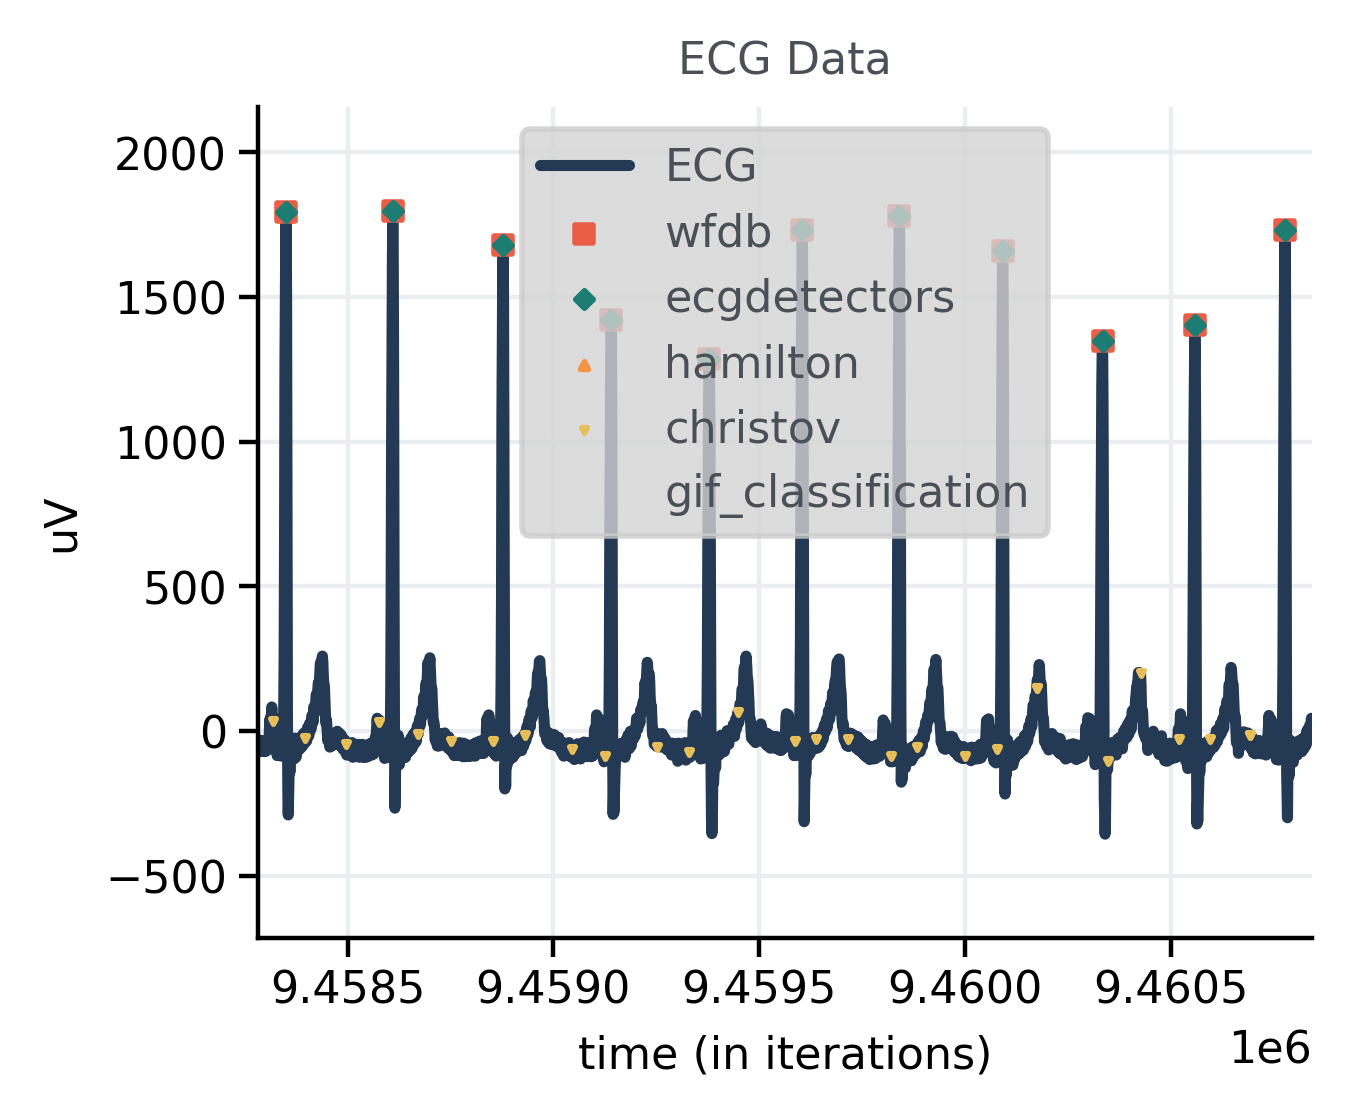

In [29]:
# choose a random file
data_directory = "Data/GIF/SOMNOwatch/"
file_data_name = "SL001_SL001_(1).edf"

file_data_path = data_directory + file_data_name

# choose size of interval
interval_size = 2560

# get r-peak function names
rpeak_function_names = parameters["rpeak_comparison_function_names"]
rpeaks = []

# load the valid regions
additions_results_generator = load_from_pickle(additions_results_path)
for generator_entry in additions_results_generator:
    if generator_entry[parameters["file_name_dictionary_key"]] == file_data_name:
        this_files_valid_ecg_regions = generator_entry[parameters["valid_ecg_regions_dictionary_key"]]
        for rpeak_function_name in rpeak_function_names:
            rpeaks.append(generator_entry[rpeak_function_name])
        break

# load the ECG data
ECG, frequency = read_edf.get_data_from_edf_channel(
    file_path = file_data_path,
    possible_channel_labels = parameters["ecg_keys"],
    physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

# choose random valid interval
random_valid_ecg_region = random.choice(this_files_valid_ecg_regions)
random_valid_ecg_region_start = random.randint(random_valid_ecg_region[0], random_valid_ecg_region[1] - interval_size)

# x_lim = [708000, 708500]
# x_lim = [1358000, 1359000]
# x_lim = [759000, 759150]
x_lim = [random_valid_ecg_region_start, random_valid_ecg_region_start + interval_size]

plot_helper.plot_rpeak_detection(
    ECG = ECG,
    rpeaks = rpeaks,
    rpeaks_name = rpeak_function_names,
    xlim = x_lim)

## R-Peak Detection Comparison

### Visualizing R-Peak Comparison

R-peaks are calculated with different libraries for multiple files and afterwards similar r-peaks collected 
(distance smaller 50ms) and compared between two different detectors. 

Following code shows a histogram of the resulting similar / total peaks ratios for one detector pair.

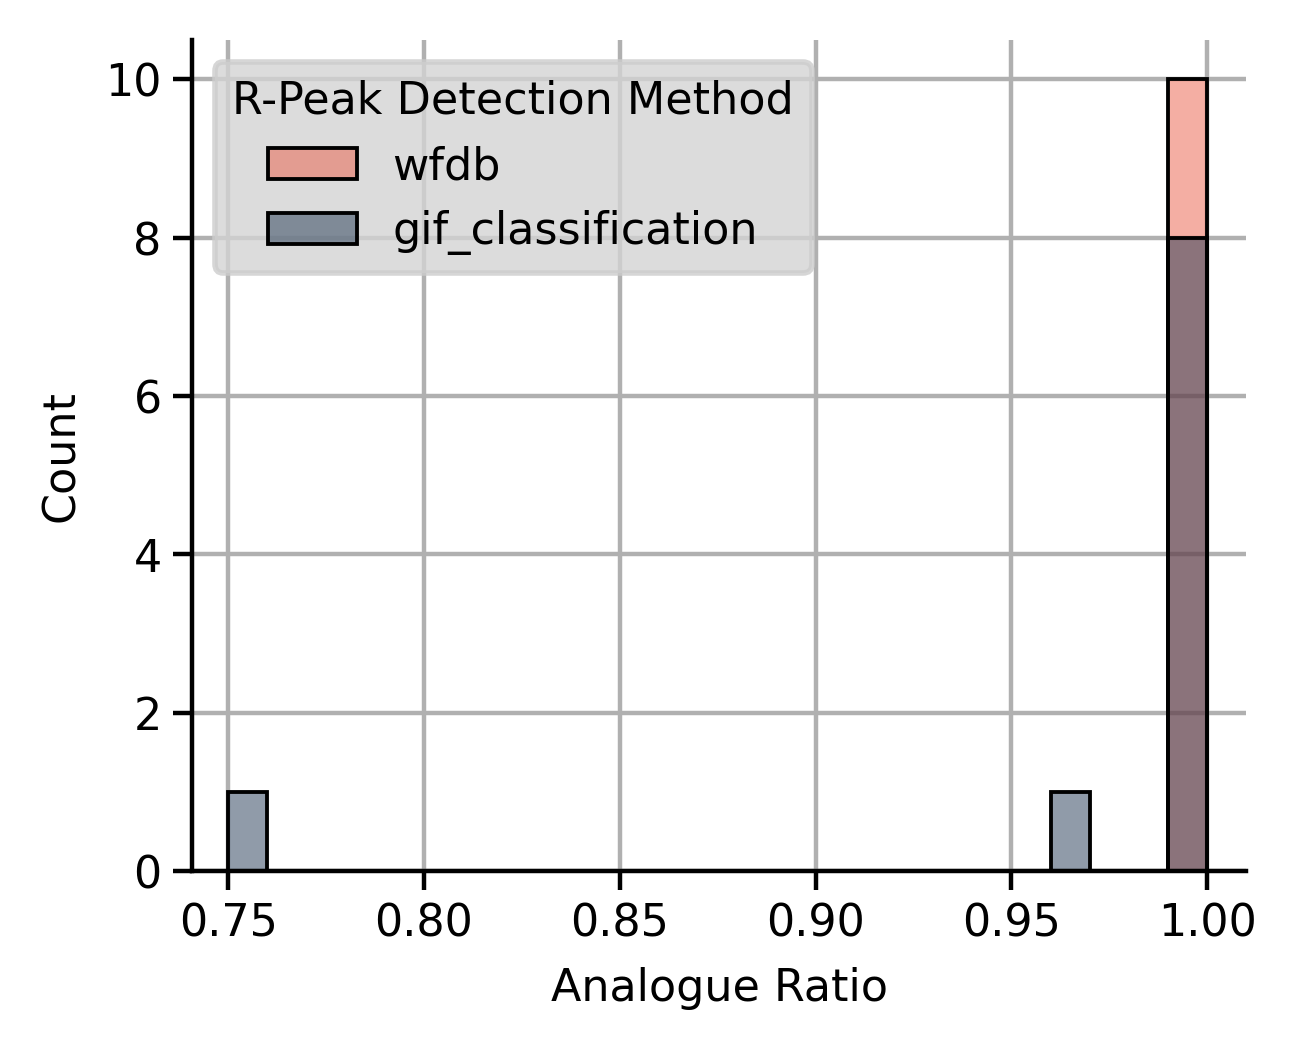

In [96]:
# choose a random detection method pair
first_function_name = "wfdb"
second_function_name = "gif_classification"

# find the position in the list
position_in_list = 0
for path_index_first in range(len(parameters["rpeak_comparison_function_names"])):
    found_pair = False
    for path_index_second in range(path_index_first+1, len(parameters["rpeak_comparison_function_names"])):
        if parameters["rpeak_comparison_function_names"][path_index_first] == first_function_name and parameters["rpeak_comparison_function_names"][path_index_second] == second_function_name:
            found_pair = True
            break
        if parameters["rpeak_comparison_function_names"][path_index_first] == second_function_name and parameters["rpeak_comparison_function_names"][path_index_second] == first_function_name:
            found_pair = True
            second_function_name = first_function_name
            first_function_name = parameters["rpeak_comparison_function_names"][path_index_second]
            break
        position_in_list += 1
    if found_pair:
        break

# load the data
analogue_ratios_first_function = []
analogue_ratios_second_function = []

additions_results_generator = load_from_pickle(additions_results_path)
for generator_entry in additions_results_generator:
    this_files_rpeak_comparison_values = generator_entry[parameters["rpeak_comparison_dictionary_key"]]
    try:
        analogue_ratios_first_function.append(this_files_rpeak_comparison_values[position_in_list][3]/this_files_rpeak_comparison_values[position_in_list][4])
    except:
        pass
    try:
        analogue_ratios_second_function.append(this_files_rpeak_comparison_values[position_in_list][3]/this_files_rpeak_comparison_values[position_in_list][5])
    except:
        pass

# plot the data
plot_helper.plot_simple_histogram(
    data = [analogue_ratios_first_function, analogue_ratios_second_function],
    label = [first_function_name, second_function_name],
    label_title = "R-Peak Detection Method",
    x_label = "Analogue Ratio",
    y_label = "Count",
    x_lim = [0, 1],
    binrange = (0.75, 1),
    kde=False,
)

### Plot Non-Intersecting R-Peaks

After comparing the r-peaks in the ADDITIONS section of the main.py file, you might want to
look at r-peak detections that do not have a lot of peaks in common. 

In the following code you can choose a file and two functions. The intersecting and non-intersecting peaks
will be calculated and one that does not match is randomly chosen and its surroundings are
plotted.

Random r-peak location: 719109


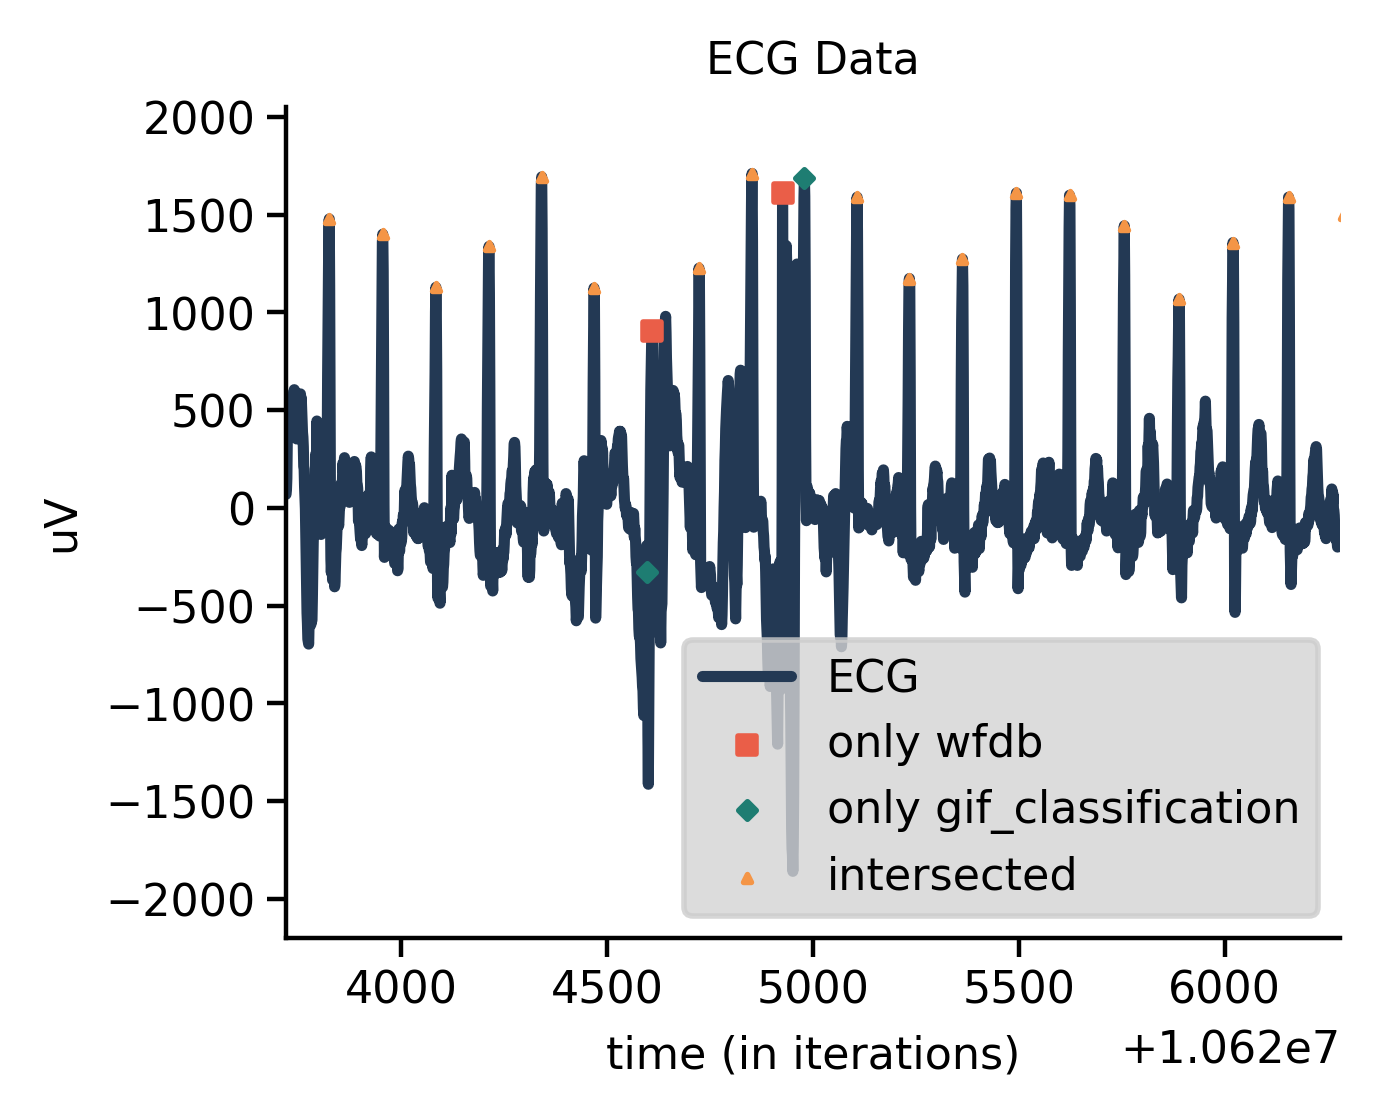

In [15]:
# choose a random file
data_directory = "Data/GIF/SOMNOwatch/"
file_data_name = "SL001_SL001_(1).edf"

file_data_path = data_directory + file_data_name

# choose size of interval
interval_size = 2560

# get r-peak function names ("wfdb", "ecgdetectors", "hamilton", "christov", "gif_classification")
first_rpeak_function_name = "wfdb"
second_rpeak_function_name = "gif_classification"

# load the valid regions
additions_results_generator = load_from_pickle(additions_results_path)
for generator_entry in additions_results_generator:
    if generator_entry[parameters["file_name_dictionary_key"]] == file_data_name:
        first_rpeaks = generator_entry[first_rpeak_function_name]
        second_rpeaks = generator_entry[second_rpeak_function_name]
        break

# load the ECG data
ECG, frequency = read_edf.get_data_from_edf_channel(
    file_path = file_data_path,
    possible_channel_labels = parameters["ecg_keys"],
    physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

# combine the r-peaks, retrieve the intersected r-peaks and the r-peaks that are only in the first or second list
rpeaks_intersected, rpeaks_only_primary, rpeaks_only_secondary = main.rpeak_detection.combine_rpeaks(
    rpeaks_primary = first_rpeaks,
    rpeaks_secondary = second_rpeaks,
    frequency = frequency,
    rpeak_distance_threshold_seconds = parameters["rpeak_distance_threshold_seconds"]
)

# choose random r-peak for plotting
random_first_rpeak = random.choice(rpeaks_only_primary)
random_second_rpeak = random.choice(rpeaks_only_secondary)
random_rpeak = random.choice([random_first_rpeak, random_second_rpeak])
print("Random r-peak location: %d" % random_rpeak)

# nice values for plotting
# random_rpeak = 10625000 # for Data/GIF/SOMNOwatch/SL001_SL001_(1).edf, wfdb, gif_classification

x_lim = [int(random_rpeak-interval_size/2), int(random_rpeak+interval_size/2)]

plot_helper.plot_rpeak_detection(
    ECG = ECG,
    rpeaks = [rpeaks_only_primary, rpeaks_only_secondary, rpeaks_intersected],
    rpeaks_name = ["only " + first_rpeak_function_name, "only " + second_rpeak_function_name, "intersected"],
    xlim = x_lim)

## Calculating MAD Values

The calculated MAD Values will be plotted in a random interval. Of course you can change the
interval size or even define the interval yourself. Go ahead and look at a few different intervals
for different files!

ATTENTION: MAD Values must have been compiled first (see main.py - PREPARATION SECTION)

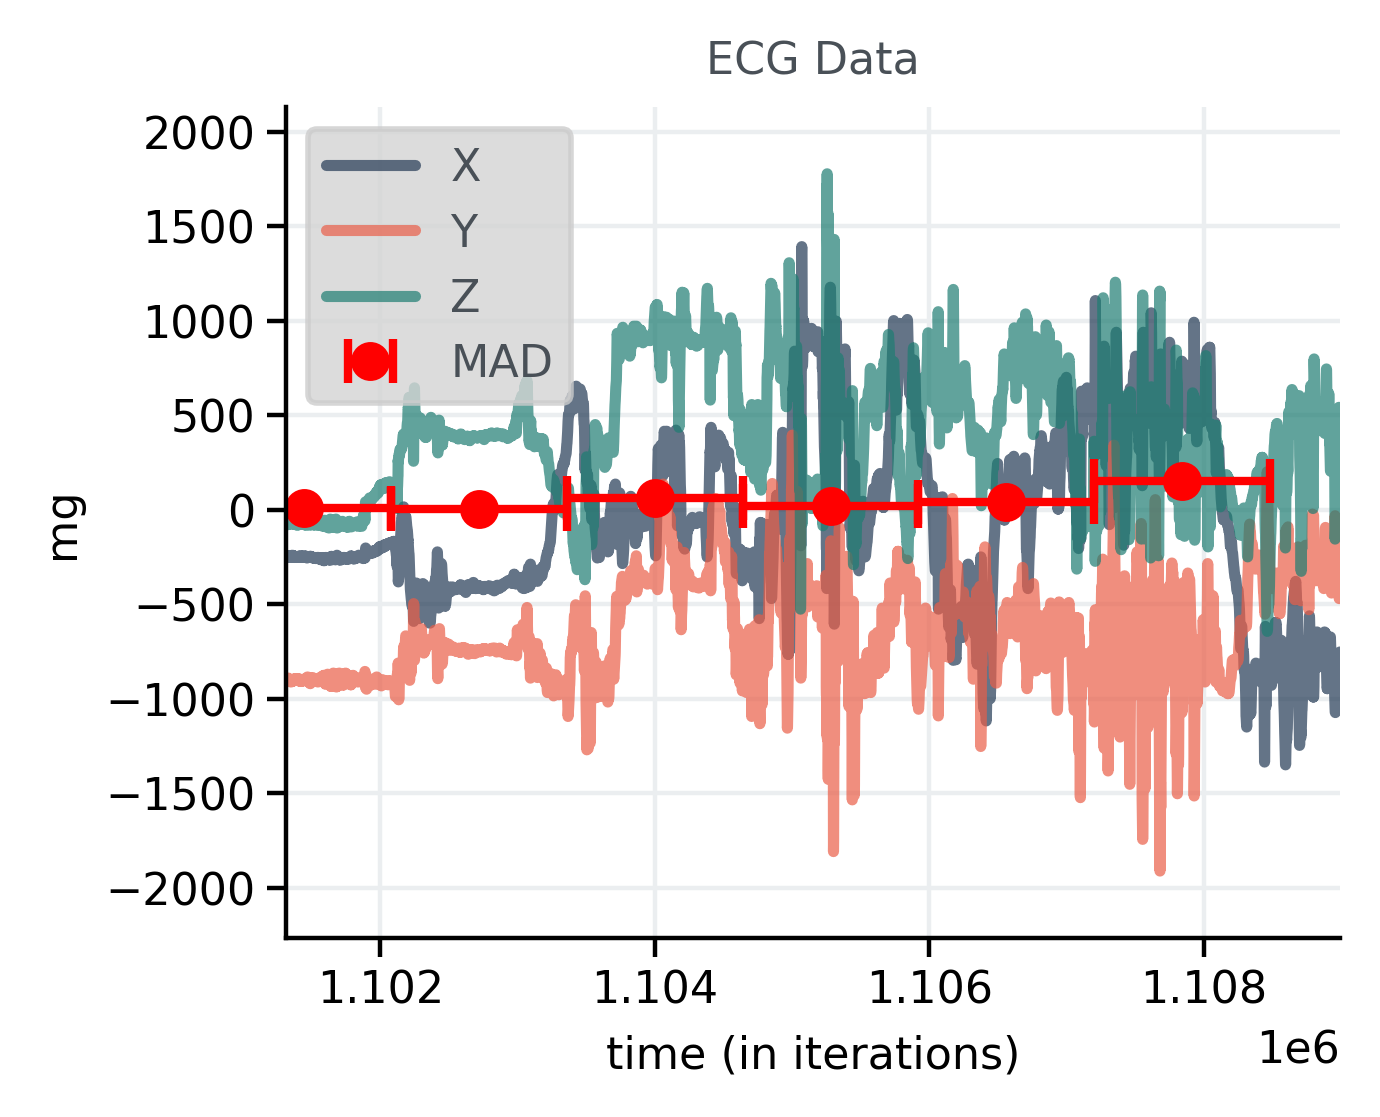

In [22]:
# choose a random file
data_directory = "Data/"
file_data_name = "Somnowatch_Messung.edf"

preparation_results_path = PREPARATION_DIRECTORY + data_directory + PREPARATION_RESULTS_NAME
file_data_path = data_directory + file_data_name

# choose size of interval
interval_size = 7680 # 60 seconds for 128 Hz

# load the MAD values
preparation_results_generator = load_from_pickle(preparation_results_path)
for generator_entry in preparation_results_generator:
    if generator_entry[parameters["file_name_dictionary_key"]] == file_data_name:
        this_files_MAD_values = generator_entry[parameters["MAD_dictionary_key"]]
        break

# create lists to save the acceleration data and frequencies for each axis
acceleration_data = []
acceleration_data_frequencies = []

# get the acceleration data and frequency for each axis
for possible_axis_keys in parameters["wrist_acceleration_keys"]:
    this_axis_signal, this_axis_frequency = read_edf.get_data_from_edf_channel(
        file_path = file_data_path,
        possible_channel_labels = possible_axis_keys,
        physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

    # append data to corresponding lists
    acceleration_data.append(this_axis_signal)
    acceleration_data_frequencies.append(this_axis_frequency)

# load data and choose random valid interval
total_length = len(acceleration_data[0])
frequency = acceleration_data_frequencies[0]

# choose random region to plot
random_valid_region_start = random.randint(0, total_length - interval_size)
random_valid_region_start = 1101312
x_lim = [random_valid_region_start, random_valid_region_start + interval_size]

plot_helper.plot_MAD_values(
    acceleration_data = acceleration_data,
    frequency = frequency,
    MAD_values = this_files_MAD_values,
    mad_time_period_seconds = parameters["mad_time_period_seconds"], 
    xlim = x_lim
    )